# I. Set up and imports

In [ ]:
!pip install -U -q PyDrive
!pip install seaborn

In [ ]:
import copy
import numpy as np
import seaborn as sns
import warnings
import scipy.io
import matplotlib.pyplot as plt
import pandas as pd

from keras import backend as K
from keras.datasets import mnist
from tqdm import tqdm
from sklearn.metrics import log_loss
from tensorflow.keras.utils import to_categorical

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
sns.set(rc = {'figure.figsize':(20, 7)})

In [ ]:
# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# Load dataset from google drive
id = '1oHcY6oSkOk_pgeGSxcrmMgpfahjAbmf5'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('binaryalphadigs.mat')
mat = scipy.io.loadmat('binaryalphadigs.mat')

# II. Restricted Boltmann Machine : an application on Binary AlphaDigits data

## a. Implementation of RBM

In [ ]:
class RBM:
  # An RBM is a neural structure with two layers.
  def __init__(self, p, q)
    # The first layer, the visible one, contains p neurons, with p equal to the numbers of columns of the input data.
    self.n_visible_layers = p
    # The second layer, the hidden one, contains q neurons.
    self.n_hidden_layers = q
    # The RBM consists of a matrix of weights, with (p,q) shape, initiliazed randomly, following a normal distribution (0, 0.1)
    self.weight = np.random.normal(0, 0.1, size = (self.n_visible_layers, self.n_hidden_layers))
    # It then consists of two bias matrix, as a null vector.
    self.bias = np.zeros((1, self.n_hidden_layers)) # Bias of hidden layers, shape (1,q)
    self.aias = np.zeros((1, self.n_visible_layers)) # Bias of visible layers, shape (1,p)

  def entree_sortie_RBM(self, x):
    # This function computes the gradient 
    return sigmoid(np.tile(self.bias, (x.shape[0], 1)) + np.dot(x, self.weight))
  
  def sortie_entree_RBM(self, h):
    return sigmoid(np.tile(self.aias, (h.shape[0], 1)) + np.dot(h, np.transpose(self.weight)))

  def train_RBM(self, epochs, learning_rate, batch_size, x):
    for epoch in range(epochs):
      mini_batches = batch(x, batch_size) # Splitting the data in mini_batches
      for mini_batch in mini_batches:
        v_0 = mini_batch.copy()
        p_h_given_v_0 = self.entree_sortie_RBM(v_0)
        h_0 = (p_h_given_v_0 > np.random.uniform(0, 1, size = p_h_given_v_0.shape)) * 1
        p_v_given_h_0 = self.sortie_entree_RBM(h_0)
        v_1 = (p_v_given_h_0 > np.random.uniform(0, 1, size = p_v_given_h_0.shape)) * 1
        p_h_given_v_1 = self.entree_sortie_RBM(v_1)
        delta_aias = np.sum(v_0 - v_1, axis = 0)
        delta_bias = np.sum(p_h_given_v_0 - p_h_given_v_1, axis = 0)
        delta_weight = np.dot(np.transpose(v_0), p_h_given_v_0) - np.dot(np.transpose(v_1), p_h_given_v_1)
        self.aias += (learning_rate / len(mini_batch)) * delta_aias
        self.bias += (learning_rate / len(mini_batch)) * delta_bias
        self.weight += (learning_rate / len(mini_batch)) * delta_weight
      h_reconstructed = self.entree_sortie_RBM(x)
      x_reconstructed = self.sortie_entree_RBM(h_reconstructed)
      mse = np.mean((x - x_reconstructed)**2)
      print('Epoch %s completed. Mean square error is %0.2f.' % (epoch + 1, mse))

  def generer_image_RBM(self, nb_iter, nb_images):
    v_0 = np.random.randint(low = 0, high = 2, size = (nb_images, self.n_visible_layers))
    p_h_given_v = self.entree_sortie_RBM(v_0)
    for i in range(nb_iter):
      h = (p_h_given_v > np.random.uniform(0, 1, size = p_h_given_v.shape))*1
      p_v_sachant_h = self.sortie_entree_RBM(h)
      v = (p_v_sachant_h > np.random.uniform(0, 1, size = p_v_sachant_h.shape))*1
      p_h_given_v = self.entree_sortie_RBM(v)
    return v

In [ ]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

In [ ]:
def compute_softmax(rbm, x):
  return (np.exp(rbm.bias + np.dot(x, rbm.weight)).T / np.sum(np.exp(rbm.bias + np.dot(x, rbm.weight)), axis = 1)).T

In [ ]:
def batch(x, batch_size):
  np.random.seed()
  x_copy = x.copy()
  n = len(x_copy)
  nb_batches = n//batch_size
  permutations = list(np.random.permutation(n))
  x_shuffled = x_copy[permutations, :]
  x_mini_batches = []
  for k in range(nb_batches):
    x_mini_batch = x_shuffled[batch_size * k : (batch_size * (k + 1)), :]
    x_mini_batches.append(x_mini_batch)
  if n%batch_size != 0 :
    x_mini_batch = x_shuffled[batch_size * nb_batches :, :]
    x_mini_batches.append(x_mini_batch)
  return x_mini_batches

In [ ]:
def lire_alpha_digit(x_all, indices):
    x = []
    for k in indices:
      for i in range(data.shape[1]):
        x.append(x_all[k][i].flatten())
    return np.array(x)

In [ ]:
def afficher_image(img):
  plt.imshow(img, cmap = 'gray')
  plt.show()

## b. Binary AlphaDigits images generation with RBM

In [ ]:
data = mat['dat']
indices = [10, 11]
x = lire_alpha_digit(data, indices)
p, q = x.shape[1], 200
rbm = RBM(p,q)
epochs = 50
learning_rate = 0.1
batch_size = 20

In [ ]:
rbm.train_RBM(epochs, learning_rate, batch_size, x)

Epoch 1 completed. Mean square error is 0.19.
Epoch 2 completed. Mean square error is 0.17.
Epoch 3 completed. Mean square error is 0.15.
Epoch 4 completed. Mean square error is 0.14.
Epoch 5 completed. Mean square error is 0.14.
Epoch 6 completed. Mean square error is 0.13.
Epoch 7 completed. Mean square error is 0.12.
Epoch 8 completed. Mean square error is 0.12.
Epoch 9 completed. Mean square error is 0.11.
Epoch 10 completed. Mean square error is 0.11.
Epoch 11 completed. Mean square error is 0.11.
Epoch 12 completed. Mean square error is 0.10.
Epoch 13 completed. Mean square error is 0.10.
Epoch 14 completed. Mean square error is 0.09.
Epoch 15 completed. Mean square error is 0.09.
Epoch 16 completed. Mean square error is 0.09.
Epoch 17 completed. Mean square error is 0.09.
Epoch 18 completed. Mean square error is 0.08.
Epoch 19 completed. Mean square error is 0.08.
Epoch 20 completed. Mean square error is 0.08.
Epoch 21 completed. Mean square error is 0.07.
Epoch 22 completed. Me

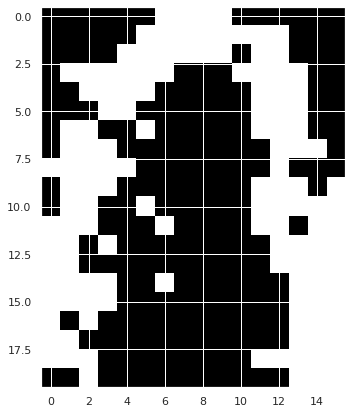

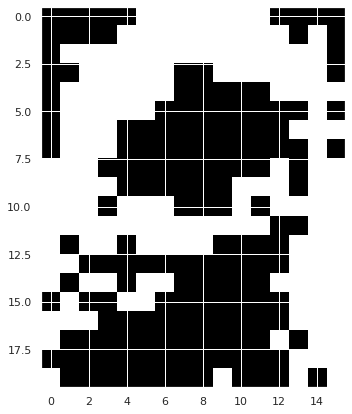

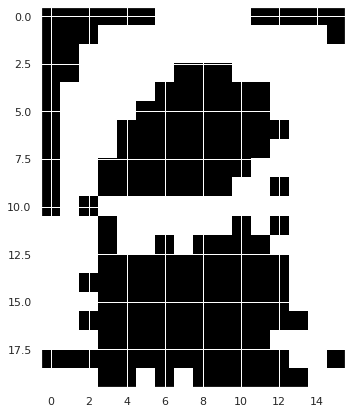

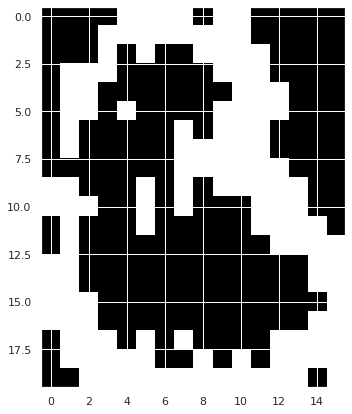

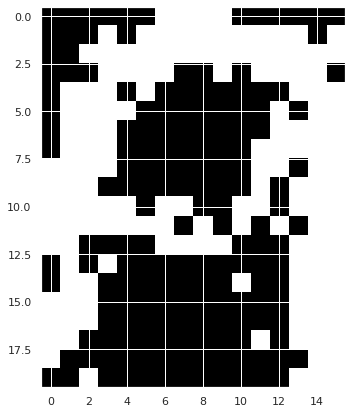

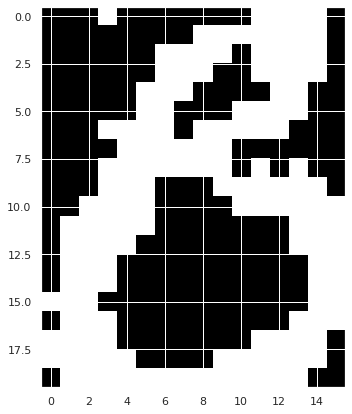

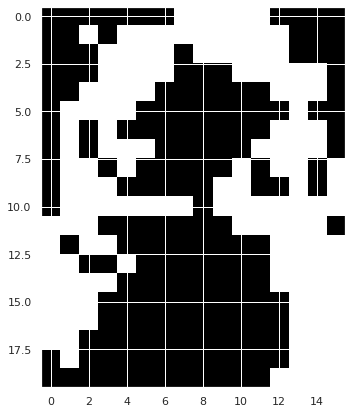

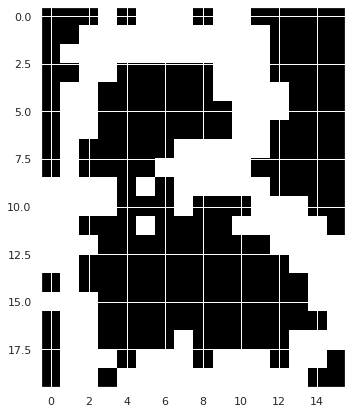

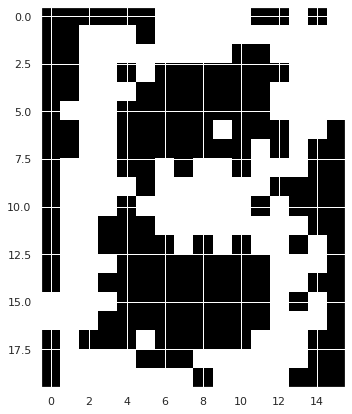

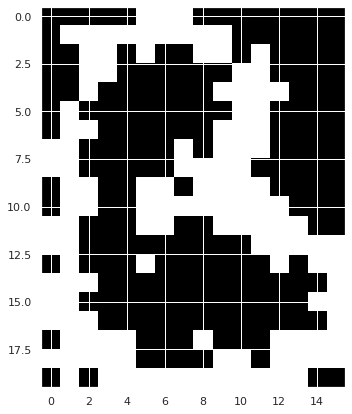

In [ ]:
nb_iter = 1000
nb_images = 10
images = rbm.generer_image_RBM(nb_iter, nb_images)
for i in range(nb_images) :
  afficher_image(images[i].reshape(20,16))

# III. Deep Neural Network : a generative graphical using RBM

## a. Implementation of Deep Belief Network

In [ ]:
class DBN:
  def __init__(self, n_layers):
    self.network_size = len(n_layers) - 1
    self.layers = []
    for i in range(1, len(n_layers)):
      self.layers.append(RBM(n_layers[i - 1], n_layers[i]))

  def pretrain_DBN(self, epochs, learning_rate, batch_size, x):
    print('Training layer 0.')
    self.layers[0].train_RBM(epochs, learning_rate, batch_size, x)
    p_h_given_v = self.layers[0].entree_sortie_RBM(x)
    h = (p_h_given_v > np.random.uniform(0, 1, size = p_h_given_v.shape)) * 1
    for i in range(1, self.network_size):
      print('Training layer %s.' % i)
      self.layers[i].train_RBM(epochs, learning_rate, batch_size, h)
      p_h_given_v = self.layers[i].entree_sortie_RBM(h)
      h = (p_h_given_v > np.random.uniform(0, 1, size = p_h_given_v.shape)) * 1
    return self

  def generer_image_DBN(self, nb_iter, nb_images):
    h_0 = np.random.randint(low = 0, high = 2, size = (nb_images, self.layers[-1].n_visible_layers))
    p_v_given_h = self.layers[-1].entree_sortie_RBM(h_0)
    for k in range(nb_iter):
      v = (p_v_given_h > np.random.uniform(0, 1, size = p_v_given_h.shape)) * 1
      p_h_given_v = self.layers[-1].sortie_entree_RBM(v)
      h = (p_h_given_v > np.random.uniform(0, 1, size = p_h_given_v.shape)) * 1
      p_v_given_h = self.layers[-1].entree_sortie_RBM(h)
    for i in range(self.network_size - 1, -1, -1):
      p_v_given_h = self.layers[i].sortie_entree_RBM(v)
      v = (p_v_given_h > np.random.uniform(0, 1, size = p_v_given_h.shape)) * 1
    return v

## b. Implementation of Deep Neural Network

In [ ]:
class DNN :
  def __init__(self, n_layers):
    self.dbn = DBN(n_layers)
    self.classification_layer = None
  
  def pretrain_DNN(self, epochs, learning_rate, batch_size, x):
    self.dbn = self.dbn.pretrain_DBN(epochs, learning_rate, batch_size, x)
    
  def generer_image_DNN(self, nb_iter, nb_images):
    return self.dbn.generer_image_DBN(nb_iter, nb_images)

  def entree_sortie_reseau(self, x):
    hidden_layers = [x]
    p_h_given_v = self.dbn.layers[0].entree_sortie_RBM(x)
    h = (p_h_given_v > np.random.uniform(0, 1, size = p_h_given_v.shape)) * 1
    hidden_layers.append(p_h_given_v)
    for i in range(1, self.dbn.network_size - 1):
      p_h_given_v = self.dbn.layers[i].entree_sortie_RBM(hidden_layers[-1])
      h = (p_h_given_v > np.random.uniform(0, 1, size = p_h_given_v.shape)) * 1
      hidden_layers.append(p_h_given_v)
    p_y_reconstructed = compute_softmax(self.dbn.layers[-1], hidden_layers[-1])
    self.classification_layer = p_y_reconstructed
    return hidden_layers, p_y_reconstructed

  def backpropagation(self, epochs, learning_rate, batch_size, x_train, y_train):
    x_mini_batches, y_mini_batches = batch_w_labels(x_train, y_train, batch_size)
    cross_entropy = []
    nb_batches = len(x_mini_batches)
    for epoch in range(epochs):
      cross_entropy_epoch = 0
      for i in range(nb_batches):
        delta_weights = []
        delta_biais = []
        hidden_layers, p_y_reconstructed = self.entree_sortie_reseau(x_mini_batches[i])
        cross_entropy_epoch += log_loss(y_mini_batches[i], p_y_reconstructed)
        c = p_y_reconstructed - y_mini_batches[i]
        delta_weights.append(np.dot(hidden_layers[-1].T, c))
        delta_biais.append(np.sum(c, axis = 0))
        for j in range(self.dbn.network_size - 2, -1, -1):
          c = np.dot(c, (self.dbn.layers[j + 1].weight).T) * hidden_layers[j + 1] * (1 - hidden_layers[j + 1])
          delta_weights.append(np.dot(hidden_layers[j].T, c))
          delta_biais.append(np.sum(c, axis = 0))
          self.dbn.layers[j + 1].weight -= (learning_rate / len(x_mini_batches[i])) * delta_weights[self.dbn.network_size - j - 2]
          self.dbn.layers[j + 1].bias -= (learning_rate / len(x_mini_batches[i])) * delta_biais[self.dbn.network_size - j - 2]
        self.dbn.layers[0].weight -= (learning_rate / len(x_mini_batches[i])) * delta_weights[-1]
        self.dbn.layers[0].bias -= (learning_rate / len(x_mini_batches[i])) * delta_biais[-1]
      cross_entropy.append(cross_entropy_epoch / nb_batches)
    return self, cross_entropy

  def test_DNN(self, x_test, y_test):
    hidden_layers, p_y_reconstructed = self.entree_sortie_reseau(x_test)
    return np.sum(np.argmax(p_y_reconstructed, axis = 1) != np.argmax(y_test, axis = 1))/y_test.shape[0]

In [ ]:
def batch_w_labels(x, y, batch_size):
  np.random.seed()
  n = len(x)
  nb_batches = n//batch_size
  permutations = list(np.random.permutation(n))
  x_shuffled = x[permutations, :]
  y_shuffled = y[permutations, :]
  x_mini_batches = []
  y_mini_batches = []
  for k in range(nb_batches):
    x_mini_batch = x_shuffled[batch_size * k : (batch_size * (k + 1)), :]
    y_mini_batch = y_shuffled[batch_size * k : (batch_size * (k + 1)), :]
    x_mini_batches.append(x_mini_batch)
    y_mini_batches.append(y_mini_batch)
  if n%batch_size != 0 :
    x_mini_batch = x_shuffled[batch_size * nb_batches :, :]
    y_mini_batch = y_shuffled[batch_size * nb_batches :, :]
    x_mini_batches.append(x_mini_batch)
    y_mini_batches.append(y_mini_batch)
  return x_mini_batches, y_mini_batches

## c. Binary AlphaDigits images generation using DNN

In [ ]:
n_layers_alpha_digits = [320, 200, 200]
dnn_alpha_digits = DNN(n_layers_alpha_digits)
dnn_alpha_digits.pretrain_DNN(epochs, learning_rate, batch_size, x)

Training layer 0.
Epoch 1 completed. Mean square error is 0.18.
Epoch 2 completed. Mean square error is 0.17.
Epoch 3 completed. Mean square error is 0.17.
Epoch 4 completed. Mean square error is 0.15.
Epoch 5 completed. Mean square error is 0.14.
Epoch 6 completed. Mean square error is 0.14.
Epoch 7 completed. Mean square error is 0.13.
Epoch 8 completed. Mean square error is 0.12.
Epoch 9 completed. Mean square error is 0.12.
Epoch 10 completed. Mean square error is 0.11.
Epoch 11 completed. Mean square error is 0.11.
Epoch 12 completed. Mean square error is 0.10.
Epoch 13 completed. Mean square error is 0.10.
Epoch 14 completed. Mean square error is 0.09.
Epoch 15 completed. Mean square error is 0.09.
Epoch 16 completed. Mean square error is 0.09.
Epoch 17 completed. Mean square error is 0.08.
Epoch 18 completed. Mean square error is 0.08.
Epoch 19 completed. Mean square error is 0.08.
Epoch 20 completed. Mean square error is 0.07.
Epoch 21 completed. Mean square error is 0.07.
Epoc

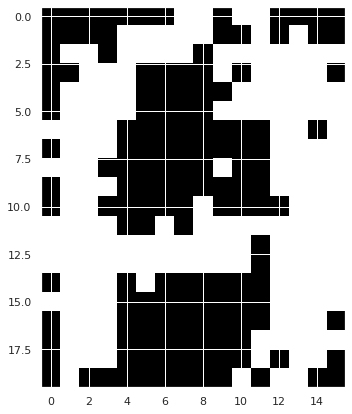

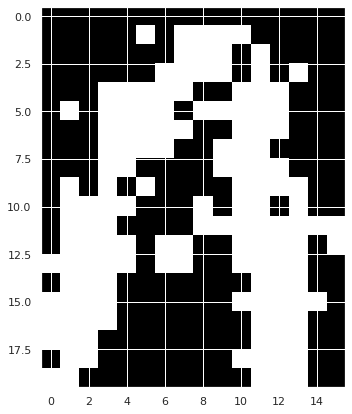

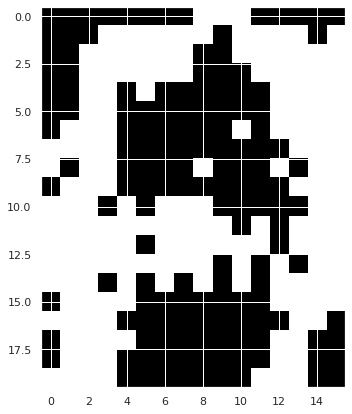

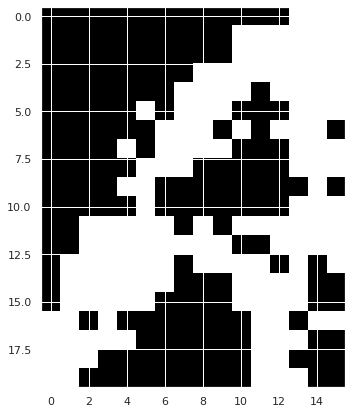

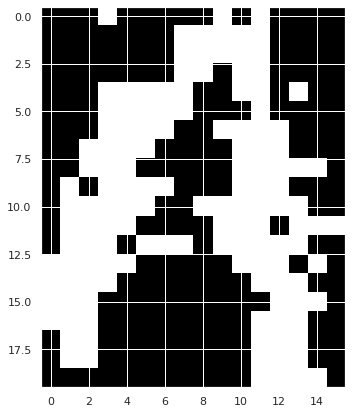

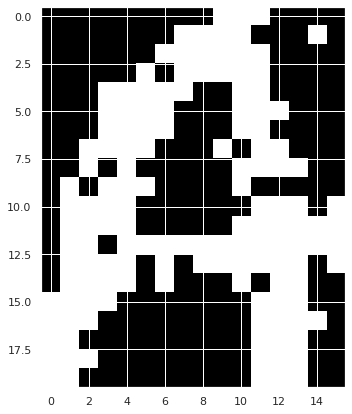

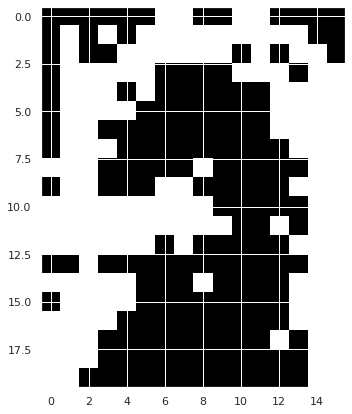

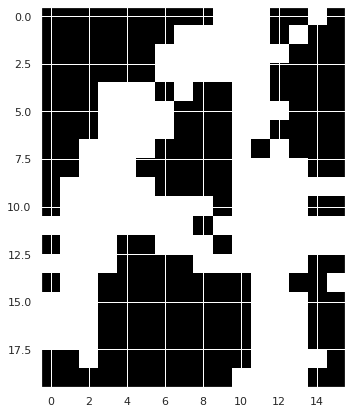

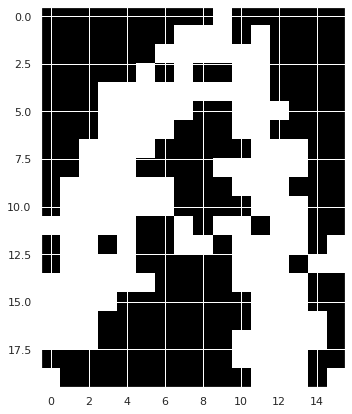

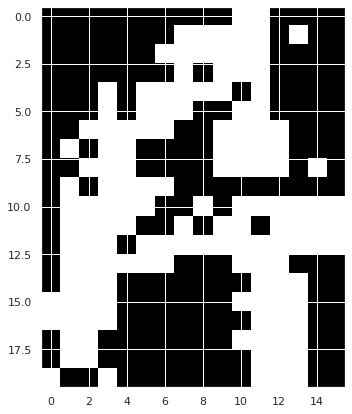

In [ ]:
images = dnn_alpha_digits.generer_image_DNN(nb_iter, nb_images)
for i in range(nb_images) :
  afficher_image(images[i].reshape(20,16))

# IV. The study of Deep Neural Network on MNIST data

## a. Data loading and fist results

In [ ]:
# Transform greyscale images into black and white
def from_greyscale_to_bw(x, threshold):
  return (x < threshold) * 0 + (x > threshold) * 1

In [ ]:
# Load the mnist dataset
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = mnist.load_data()

num_train  = x_train_mnist.shape[0]
num_test   = x_test_mnist.shape[0]

img_height = x_train_mnist.shape[1]
img_width  = x_train_mnist.shape[2]
x_train_mnist = x_train_mnist.reshape((num_train, img_width * img_height))
x_test_mnist  = x_test_mnist.reshape((num_test, img_width * img_height))

# Get the mnist images in black and white
threshold = 128
x_train_mnist_bw = from_greyscale_to_bw(x_train_mnist, threshold)
x_test_mnist_bw = from_greyscale_to_bw(x_test_mnist, threshold)

print('x_train_mnist shape:', x_train_mnist.shape)
print('x_test_mnist shape:', x_test_mnist.shape)
print(' ')

y_train_mnist = to_categorical(y_train_mnist, num_classes = 10)
y_test_mnist = to_categorical(y_test_mnist, num_classes = 10)

print('y_train_mnist shape:', y_train_mnist.shape)
print('y_test_mnist shape:', y_test_mnist.shape)

11493376/11490434 [==============================] - 0s 0us/step
x_train_mnist shape: (60000, 784)
x_test_mnist shape: (10000, 784)
 
y_train_mnist shape: (60000, 10)
y_test_mnist shape: (10000, 10)


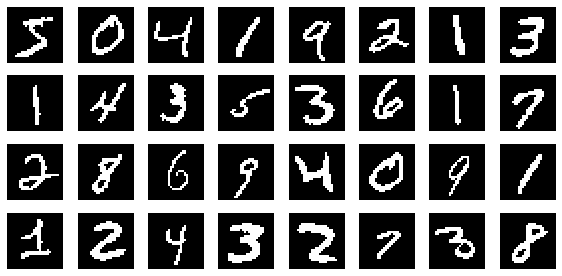

In [ ]:
# Display some mnist images
n_rows = 4
n_cols = 8
plt.figure(figsize=(8, 4))
for i in range(n_rows * n_cols):
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(x_train_mnist_bw[i].reshape(28, 28),
               interpolation = "none", cmap = "gray")
    plt.axis("off")
plt.tight_layout()

In [ ]:
# Backpropagation and entropy computing on an untrained DNN
%%capture
n_layers_mnist = [784, 200, 200, 10]
epochs_mnist = 100
learning_rate_mnist = 0.1
batch_size_mnist = 120

dnn_mnist = DNN(n_layers_mnist)
dnn_mnist.pretrain_DNN(epochs_mnist, learning_rate_mnist, batch_size_mnist, x_train_mnist_bw)
dnn_back, entropy = dnn_mnist.backpropagation(epochs_mnist, learning_rate_mnist, batch_size_mnist, x_train_mnist_bw, y_train_mnist)

[Text(0, 0.5, 'Cross entropy'),
 Text(0.5, 0, 'Epochs'),
 Text(0.5, 1.0, 'Decreasing of cross entropy depending on number of epochs')]

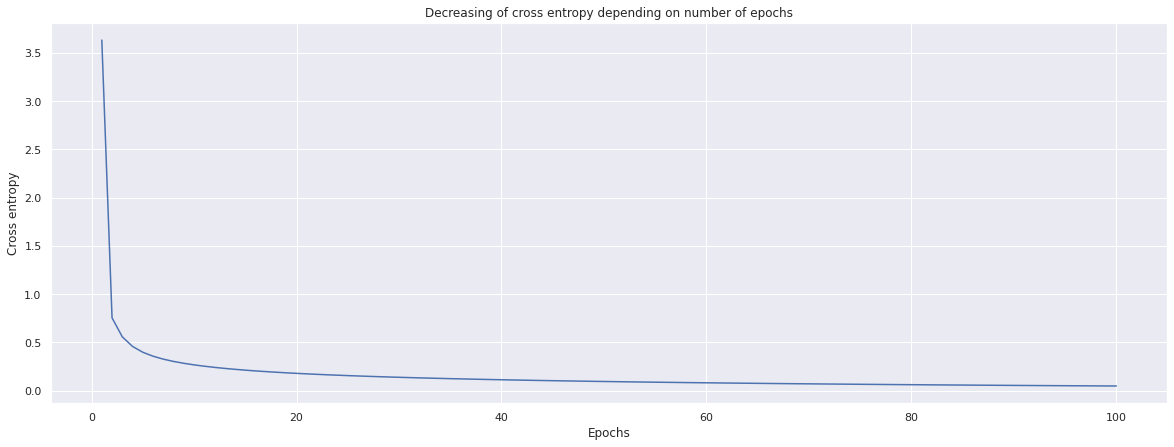

In [ ]:
df_mnist_performances = pd.DataFrame(columns = ['Cross Entropy', 'Epochs'])
df_mnist_performances['Cross Entropy'] = np.array(entropy)
df_mnist_performances['Epochs'] = np.array([i for i in range(1, epochs_mnist + 1)])
fig = sns.lineplot(x = 'Epochs', y = 'Cross Entropy', data = df_mnist_performances)
fig.set(xlabel = 'Epochs', ylabel = 'Cross entropy', title = 'Decreasing of cross entropy depending on number of epochs')

## b. Evolution of the test error as a function of the number of layers

In [ ]:
%%capture
# Figure 1
## Initializing parameters
epochs_RBM_1 = 100
epochs_BP_1 = 200
learning_rate_1 = 0.1
batch_size_1 = 120
n_layers_1 = [ [784] + [200] * i + [10] for i in range(2,6)]
error_1 = {'untrained' : { str(i) + '*200' : 0 for i in range(2,6)}, 'pretrained' : { str(i) + '*200' : 0 for i in range(2,6)}}

for i, layer in enumerate(n_layers_1):
  ## Initializing DNN
  dnn_untrained_1 = DNN(layer)
  dnn_pretrained_1 = copy.deepcopy(dnn_untrained_1)

  ## Unsupervised training on the second DNN
  dnn_pretrained_1.pretrain_DNN(epochs_RBM_1, learning_rate_1, batch_size_1, x_train_mnist_bw)

  ## Backpropagation on DNN
  dnn_untrained_back_1, entropy_untrained_1 = dnn_untrained_1.backpropagation(epochs_BP_1, learning_rate_1, batch_size_1, x_train_mnist_bw, y_train_mnist)
  dnn_pretrained_back_1, entropy_pretrained_1 = dnn_pretrained_1.backpropagation(epochs_BP_1, learning_rate_1, batch_size_1, x_train_mnist_bw, y_train_mnist)

  ## Compute classifications' errors
  error_1['untrained'][str(i + 2) + '*200'] = dnn_untrained_back_1.test_DNN(x_test_mnist_bw, y_test_mnist)
  error_1['pretrained'][str(i + 2) + '*200'] = dnn_pretrained_back_1.test_DNN(x_test_mnist_bw, y_test_mnist)

In [ ]:
df_error_1 = pd.DataFrame(error_1)
df_error_1

,untrained,pretrained
2*200,0.0266,0.0303
3*200,0.0275,0.0262
4*200,0.0302,0.0262
5*200,0.0323,0.0215


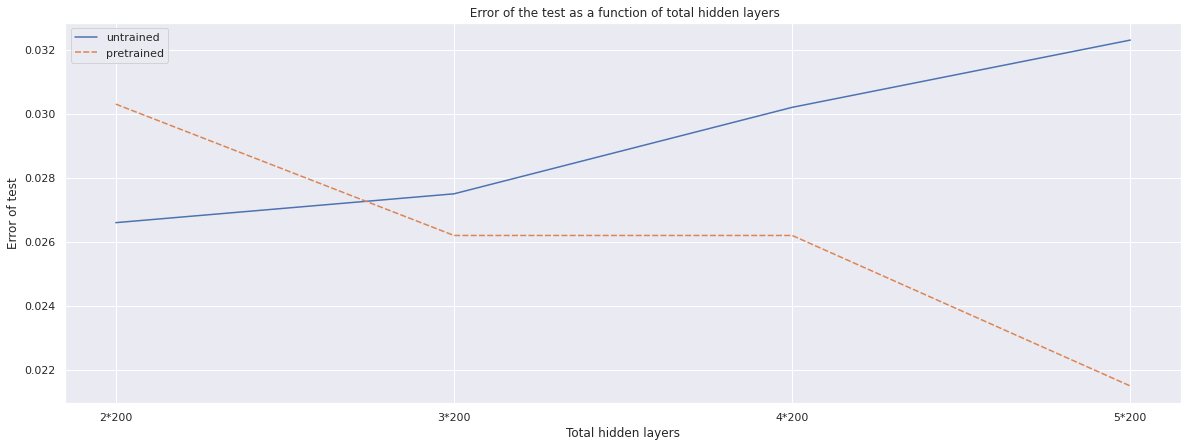

In [ ]:
sns.set(rc={'figure.figsize':(20, 7)})
fig= sns.lineplot(data=df_error_1, legend = 'auto')
fig.set(xlabel = 'Total hidden layers', ylabel = 'Error of test', title = 'Error of the test as a function of total hidden layers')
fig.legend()

## c. Evolution of the test error as a function of the number of neurons

In [ ]:
%%capture
# Figure 2
## Initializing parameters
epochs_RBM_2 = 100
epochs_BP_2 = 200
learning_rate_2 = 0.1
batch_size_2 = 120
n_layers_2 = [ [784] + [i * 100, i * 100] + [10] for i in range(1,8)]
error_2 = {'untrained' : {str(i) + '00' : 0 for i in range(1,8)}, 'pretrained' : { str(i) + '00' : 0 for i in range(1,8)}}

for i, layer in enumerate(n_layers_2):
  ### Initializng DNN
  dnn_untrained_2 = DNN(layer)
  dnn_pretrained_2 = copy.deepcopy(dnn_untrained_2)

  ### Unsupervised training on the second DNN
  dnn_pretrained_2.pretrain_DNN(epochs_RBM_2, learning_rate_2, batch_size_2, x_train_mnist_bw)

  ### Backpropagation on DNN
  dnn_untrained_back_2, entropy_untrained_2 = dnn_untrained_2.backpropagation(epochs_BP_2, learning_rate_2, batch_size_2, x_train_mnist_bw, y_train_mnist)
  dnn_pretrained_back_2, entropy_pretrained_2 = dnn_pretrained_2.backpropagation(epochs_BP_2, learning_rate_2, batch_size_2, x_train_mnist_bw, y_train_mnist)

  ### Compute classifications' errors
  error_2['untrained'][str(i + 1) + '00'] = dnn_untrained_back_2.test_DNN(x_test_mnist_bw, y_test_mnist)
  error_2['pretrained'][str(i + 1) + '00'] = dnn_pretrained_back_2.test_DNN(x_test_mnist_bw, y_test_mnist)

In [ ]:
df_error_2 = pd.DataFrame(error_2)
df_error_2

,untrained,pretrained
100,0.0284,0.0394
200,0.0257,0.0311
300,0.0242,0.0286
400,0.0249,0.0267
500,0.0236,0.0237
600,0.0253,0.0256
700,0.0245,0.0286


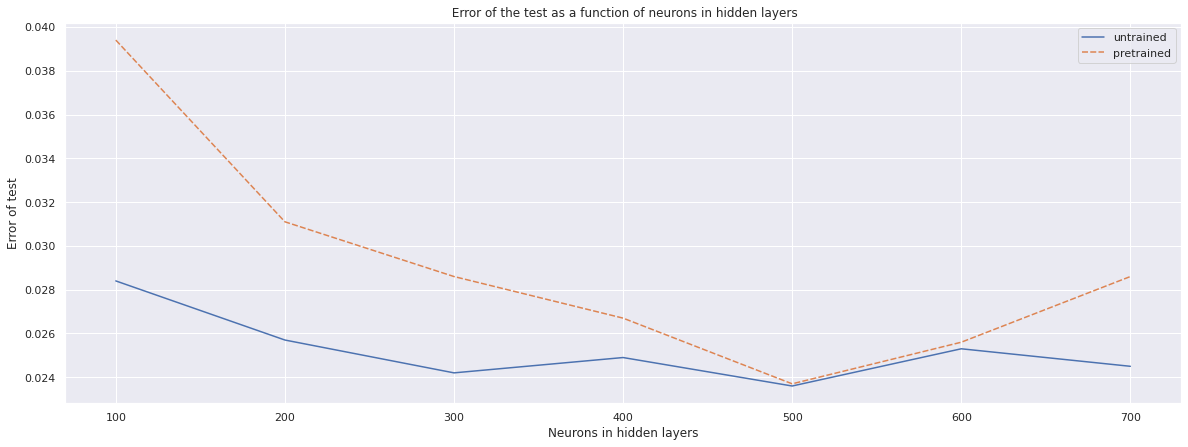

In [ ]:
sns.set(rc={'figure.figsize':(20, 7)})
fig= sns.lineplot(data = df_error_2, legend = 'auto')
fig.set(xlabel = 'Neurons in hidden layers', ylabel = 'Error of test', title = 'Error of the test as a function of neurons in hidden layers')
fig.legend()

## c. Evolution of the test error as a function of the number of training data

In [ ]:
%%capture
# Figure 3
## Initializing parameters

epochs_RBM_3 = 100
epochs_BP_3 = 200
learning_rate_3 = 0.1
batch_size_3 = 120
n_layers_3 = [784] + [200] * 5 + [10]
n_train_data = [1000, 3000, 7000, 10000, 30000, 60000]
error_3 = {'untrained' : {str(i) : 0  for i in n_train_data}, 'pretrained' : {str(i) : 0  for i in n_train_data}}

for i in n_train_data :
  ### Initializng DNN
  dnn_untrained_3 = DNN(n_layers_3)
  dnn_pretrained_3 = copy.deepcopy(dnn_untrained_3)

  ### Unsupervised training on the second DNN
  dnn_pretrained_3.pretrain_DNN(epochs_RBM_3, learning_rate_3, batch_size_3, x_train_mnist_bw[:i])

  ### Backpropagation on DNN
  dnn_untrained_back_3, entropy_untrained_3 = dnn_untrained_3.backpropagation(epochs_BP_3, learning_rate_3, batch_size_3, x_train_mnist_bw[:i], y_train_mnist[:i])
  dnn_pretrained_back_3, entropy_pretrained_3 = dnn_pretrained_3.backpropagation(epochs_BP_3, learning_rate_3, batch_size_3, x_train_mnist_bw[:i], y_train_mnist[:i])

  ### Compute classifications' errors
  error_3['untrained'][str(i)] = dnn_untrained_back_3.test_DNN(x_test_mnist_bw, y_test_mnist)
  error_3['pretrained'][str(i)] = dnn_pretrained_back_3.test_DNN(x_test_mnist_bw, y_test_mnist)

In [ ]:
df_error_3 = pd.DataFrame(error_3)
df_error_3

,untrained,pretrained
1000,0.8801,0.1320
3000,0.1645,0.0826
7000,0.0988,0.0590
10000,0.0837,0.0490
30000,0.0419,0.0301
60000,0.0351,0.0224


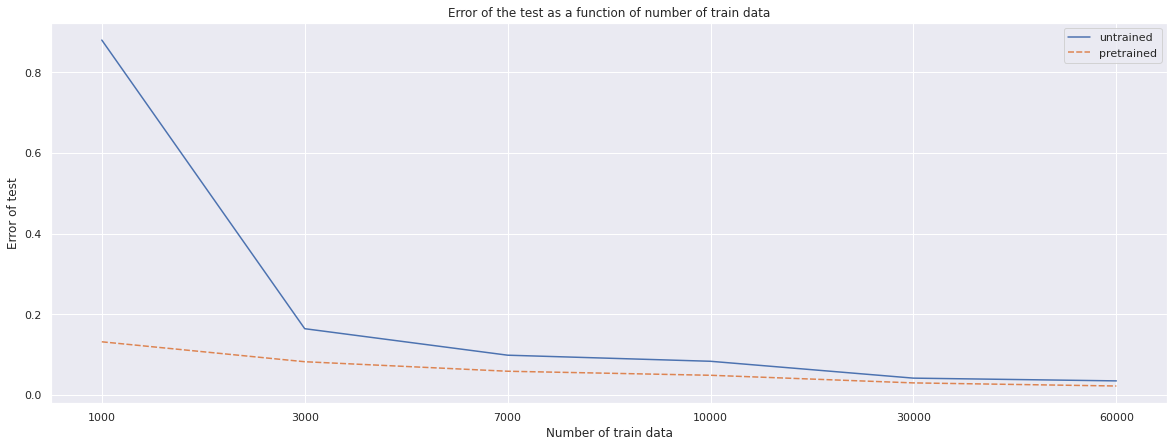

In [ ]:
sns.set(rc={'figure.figsize':(20, 7)})
fig= sns.lineplot(data = df_error_3, legend = 'auto')
fig.set(xlabel = 'Number of train data', ylabel = 'Error of test', title = 'Error of the test as a function of number of train data')
fig.legend()

## d. Search of the optimal configuration of DNN for MNIST dataset

### i. Increasing the number of layers

In [ ]:
%%capture
"We here try to combine our previous best configurations for each figure"

# Backpropagation and entropy computing on an untrained DNN
n_layers_mnist = [784, 500, 500, 500, 500, 500, 10]
epochs_mnist = 100
learning_rate_mnist = 0.1
batch_size_mnist = 120

dnn_mnist = DNN(n_layers_mnist)
dnn_mnist.pretrain_DNN(epochs_mnist, learning_rate_mnist, batch_size_mnist, x_train_mnist_bw)
dnn_back, entropy = dnn_mnist.backpropagation(epochs_mnist, learning_rate_mnist, batch_size_mnist, x_train_mnist_bw, y_train_mnist)
error = dnn_mnist.test_DNN(x_test_mnist_bw, y_test_mnist)

In [ ]:
print(error)

0.0227


In [ ]:
%%capture
# Figure 4  
## Initializing parameters
epochs_RBM_4 = 100
epochs_BP_4 = 200
learning_rate_4 = 0.1
batch_size_4 = 120
n_layers_4 = [ [784] + [200] * i + [10] for i in range(6,11)]
error_4 = {'pretrained' : { str(i) + '00' : 0 for i in range(6,11)}}
str(i) + '*200' : 0 for i in range
for i, layer in tqdm(enumerate(n_layers_4)):
  ### Initializng DNN
  dnn_pretrained_4 = DNN(layer)

  ### Unsupervised training on the DNN
  dnn_pretrained_4.pretrain_DNN(epochs_RBM_4, learning_rate_4, batch_size_4, x_train_mnist_bw)

  ### Backpropagation on DNN
  dnn_pretrained_back_4, entropy_pretrained_4 = dnn_pretrained_4.backpropagation(epochs_BP_4, learning_rate_4, batch_size_4, x_train_mnist_bw, y_train_mnist)

  ### Compute classifications' errors
  error_4['pretrained'][str(i + 6) + '*200'] = dnn_pretrained_back_4.test_DNN(x_test_mnist_bw, y_test_mnist)

In [ ]:
df_error_4 = pd.DataFrame(error_4)
df_error_4

,pretrained
6*200,0.0244
7*200,0.0239
8*200,0.0257
9*200,0.0282
10*200,0.0275


[Text(0, 0.5, 'Error of test'),
 Text(0.5, 0, 'Neurons in hidden layers'),
 Text(0.5, 1.0, 'Error of the test as a function of neurons in hidden layers')]

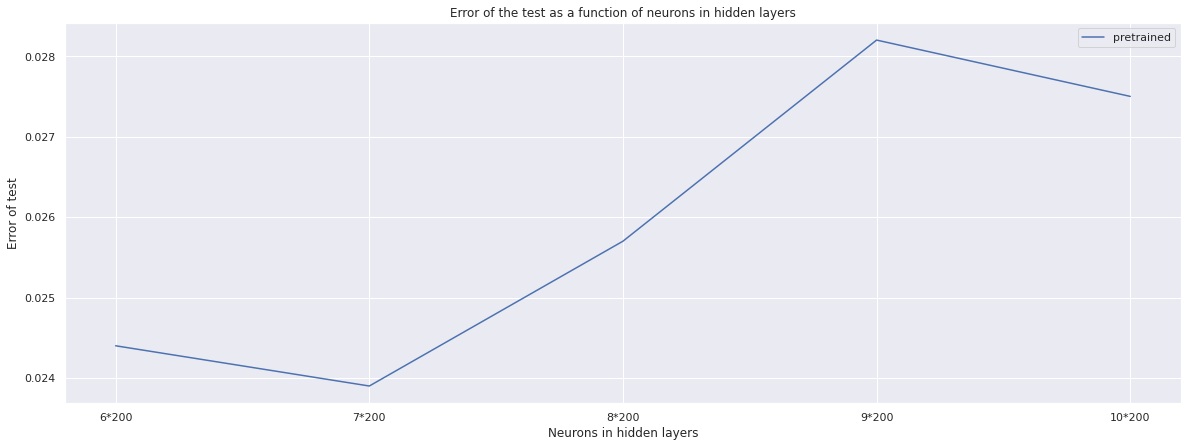

In [ ]:
sns.set(rc={'figure.figsize':(20, 7)})
fig = sns.lineplot(data = df_error_4, legend = 'auto')
fig.set(xlabel = 'Neurons in hidden layers', ylabel = 'Error of test', title = 'Error of the test as a function of neurons in hidden layers')

### ii. Random search approach

In [ ]:
%%capture
# Figure 5
## Initializing parameters
epochs_RBM_5 = 100
epochs_BP_5 = 200
learning_rate_5 = 0.1
batch_size_5= 120
n_layers_5=[]

for j in range(3):
  n_lay = random.randint(2,5)
  randomlist=[784]
  for i in range(0,n_lay):
    n = random.randint(200,500)
    randomlist.append(n)
  randomlist.append(10)
  n_layers_5.append(randomlist)

error_5 = {str(n_layers_5[0]) : 0 , str(n_layers_5[1]) :0, str(n_layers_5[2]) :0}

for i, layer in enumerate(n_layers_5):
  ### Initializng DNN
  dnn_5 = DNN(layer)
 
  ### Unsupervised training on the second DNN
  dnn_5.pretrain_DNN(epochs_RBM_5, learning_rate_5, batch_size_5, x_train_mnist_bw[:10000])

  ### Backpropagation on DNN
  dnn_pretrained_5, entropy_pretrained_5 = dnn_5.backpropagation(epochs_BP_5, learning_rate_5, batch_size_5, x_train_mnist_bw[:10000], y_train_mnist[:10000]) ### Compute classifications' errors
  error_5[str(n_layers_5[i])] = dnn_pretrained_5.test_DNN(x_test_mnist_bw, y_test_mnist)

In [ ]:
pd.DataFrame(error_5,index=['Error of the DNN'])

,"[784, 442, 493, 247, 317, 10]","[784, 443, 485, 290, 493, 460, 10]","[784, 222, 432, 317, 10]"
Error of the DNN,0.0563,0.0502,0.0542
